In [15]:
from indicator import plot_window_landscapes
from datetime import date

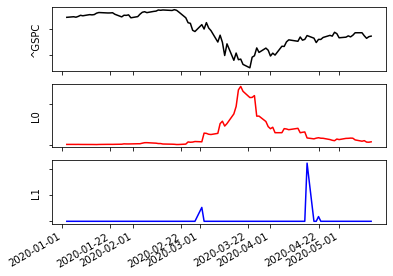

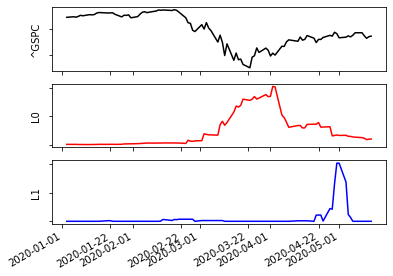

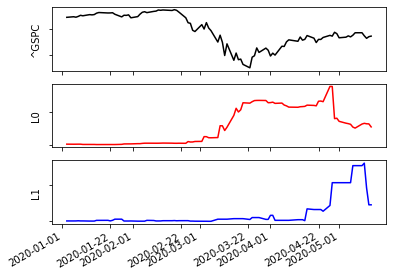

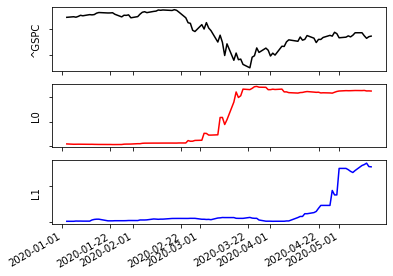

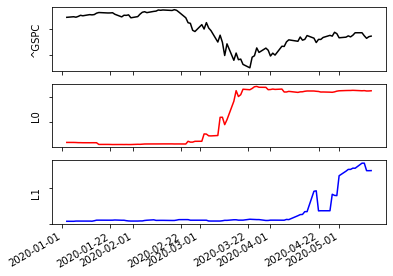

In [17]:
for w in [7,14,30,60,100]:
    plot_window_landscapes(
        start_dt="2020-01-01",
        end_dt=str(date.today()),
        ticker_symbol_list=["^GSPC","^DJI","^IXIC","^RUT"],
        window_size=w
    )